In [1]:
import numpy as np
import librosa
import os
import pyedflib
import json
import sklearn
import matplotlib.pyplot as plt
import mne
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn import neighbors
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, classification_report

In [2]:
data = np.zeros((1,8,250))
marks = []

dir_str = os.path.dirname(os.path.abspath("__file__"))+("\data")
data_dir = Path(dir_str)
print(data_dir)

for file in data_dir.iterdir():
    if file.suffix == ".edf":
        #exclude spoiled files
        if "spoiled" in file.__str__():
            continue

        #exclude noisy files
        #if "noisy" in file.__str__():
        #    continue
        
        loaded_data = mne.io.read_raw_edf(file.__str__())
        loaded_data.load_data()
        
        events = mne.events_from_annotations(loaded_data)
        arr_events = events[0]
        dict = events[1]
        event_names = []
        print(dict)

        #forming event names array
        if "right answer" in dict:
            event_names.append(dict["right answer"])
        if "right_answer" in dict:
            event_names.append(dict["right_answer"])
        if "fake wrong answer" in dict:
            event_names.append(dict["fake wrong answer"])
        if "wrong answer, shown" in dict:
            event_names.append(dict["wrong answer, shown"])
        if "wrong answer" in dict:
            event_names.append(dict["wrong answer"])
        if "wrong_answer" in dict:
            event_names.append(dict["wrong_answer"])
        print(event_names)

        #add filters
        filtered_data = loaded_data.copy().filter(l_freq=None, h_freq=40., fir_design='firwin', method='iir', iir_params=None)
        filtered_data = filtered_data.copy().filter(l_freq=2.,h_freq=None, fir_design='firwin', method='iir', iir_params=None)
        raw_data = filtered_data.get_data()

        #forming answers event array
        num = 0
        for i in range(arr_events.shape[0]):
            if arr_events[i,2] in event_names:
                num = i
                if (arr_events[i,0] == arr_events[i+1,0]):
                    break

        #separate asnwers (125 dots, 1 sec)
        ans_data = np.zeros((1,8,250))
        for i in range(num):
            if arr_events[i,2] in event_names:
                for j in range(20):
                    ans = raw_data[:,(arr_events[i,0]+j):(arr_events[i,0]+250+j)]
                    ans = ans.reshape(1,ans.shape[0],ans.shape[1])
                    ans_data = np.concatenate((ans_data, ans), axis=0)
                    if arr_events[i,2] == event_names[0]:
                        marks.append(1)
                    else:
                        marks.append(0)
        ans_data = ans_data[1:,:,:]
        data = np.concatenate((data, ans_data), axis=0)
        
data = data[1:,:,:]
#clear_output()
data.shape

C:\Users\Ilya\Documents\GitHub\EEG_feedback\EEG_preprocessing\data
Extracting EDF parameters from C:\Users\Ilya\Documents\GitHub\EEG_feedback\EEG_preprocessing\data\eeg-03-05-23_16-35 (9, noisy).edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 205624  =      0.000 ...  1644.992 secs...
Used Annotations descriptions: ['end task', 'right_answer', 'start task', 'wrong_answer']
{'end task': 1, 'right_answer': 2, 'start task': 3, 'wrong_answer': 4}
[2, 4]
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 40.00 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal fi

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 8 and the array at index 1 has size 6

In [4]:
A = np.array([[[[ 1, 0], [0,  2]],  [[ 3, 0], [0,  4]],  [[17, 0], [0, 18]],  [[19, 0], [0, 20]],  [[33, 0], [0, 34]]],
              [[[ 5, 0], [0,  6]],  [[ 7, 0], [0,  8]],  [[21, 0], [0, 22]],  [[23, 0], [0, 24]],  [[35, 0], [0, 36]]],
              [[[ 9, 0], [0, 10]],  [[11, 0], [0, 12]],  [[25, 0], [0, 26]],  [[27, 0], [0, 28]],  [[37, 0], [0, 38]]],
              [[[13, 0], [0, 14]],  [[15, 0], [0, 16]],  [[29, 0], [0, 30]],  [[31, 0], [0, 32]],  [[39, 0], [0, 40]]]])
print(A.shape)

B = np.array([])
for i in range(A.shape[0]):
    if i%2 != 0:
        print(i)
        continue
    for j in range(A.shape[1]):
        for m in range(A.shape[2]):
            B = np.append(B, A[i][j][m])
            B = np.append(B, A[i+1][j][m])
B = B.reshape(2,5,2,4)


(4, 5, 2, 2)
1
3


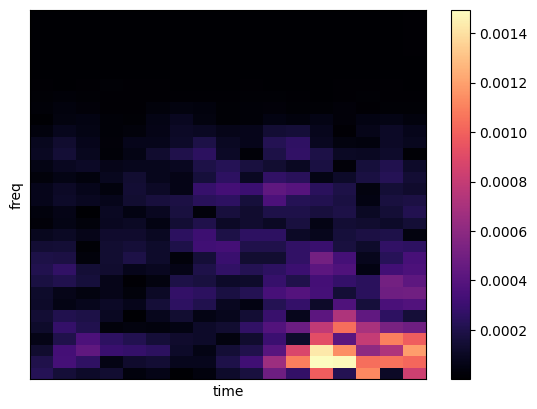

In [96]:
#stft experiments
stft = librosa.core.stft(data, n_fft=62)
spec = np.abs(stft)

#B = np.array([])
#for i in range(spec.shape[0]):
#    if i%2 != 0:
#        continue
#    for j in range(spec.shape[1]):
#        for m in range(spec.shape[2]):
#            B = np.append(B, spec[i][j][m])
#            B = np.append(B, spec[i+1][j][m])

#spec = B.reshape(int(spec.shape[0]/2),spec.shape[1],spec.shape[2],spec.shape[3]*2)
librosa.display.specshow(spec[0][0], sr=125.00)
plt.xlabel("time")
plt.ylabel("freq")
plt.colorbar()
plt.show()

In [97]:
print(spec.shape)

(1000, 8, 32, 17)


In [98]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

In [99]:
spec = spec.swapaxes(1,3)

In [68]:
model = Sequential()
model.add(Conv2D(32, 3, activation='relu', input_shape=(spec[0].shape)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=['accuracy'])
model.summary()

ValueError: Exception encountered when calling layer "conv2d_75" (type Conv2D).

Negative dimension size caused by subtracting 3 from 2 for '{{node conv2d_75/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](Placeholder, conv2d_75/Conv2D/ReadVariableOp)' with input shapes: [?,6,2,32], [3,3,32,64].

Call arguments received by layer "conv2d_75" (type Conv2D):
  • inputs=tf.Tensor(shape=(None, 6, 2, 32), dtype=float32)

In [119]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(spec[0].shape)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 15, 30, 32)        2336      
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 7, 15, 32)         0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 5, 13, 32)         9248      
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 2, 6, 32)          0         
 ng2D)                                                           
                                                                 
 flatten_10 (Flatten)        (None, 384)               0         
                                                                 
 dense_17 (Dense)            (None, 256)             

In [105]:
model = Sequential()
model.add(Conv2D(16, 2, activation='relu', input_shape=(spec[0].shape)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, 2, activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, 2, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, 2, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_104 (Conv2D)         (None, 16, 31, 16)        528       
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 8, 15, 16)         0         
 ng2D)                                                           
                                                                 
 conv2d_105 (Conv2D)         (None, 7, 14, 16)         1040      
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 3, 7, 16)          0         
 ng2D)                                                           
                                                                 
 conv2d_106 (Conv2D)         (None, 2, 6, 16)          1040      
                                                                 
 batch_normalization_51 (Ba  (None, 2, 6, 16)        

In [28]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(spec[0].shape)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 31, 16)         4624      
                                                                 
 batch_normalization (Batch  (None, 6, 31, 16)         64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 29, 16)         2320      
                                                                 
 batch_normalization_1 (Bat  (None, 4, 29, 16)         64        
 chNormalization)                                                
                                                                 
 flatten (Flatten)           (None, 1856)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [106]:
#forming data array
X = spec.copy()
X.shape

#forming true answers array
Y = np.array(marks)
Y.shape

x_t = X[240:,:,:,:]
x_test = X[:240,:,:,:]
y_t = Y[240:]
y_test = Y[:240]
        
x_train, x_val, y_train, y_val = train_test_split(x_t, y_t, test_size=0.25, random_state=20)

print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

train = (x_train.copy(), y_train.copy())
val = (x_val.copy(), y_val.copy())

(570, 17, 32, 8) (190, 17, 32, 8) (570,) (190,)


In [107]:
model.fit(x=x_train.copy(), y=y_train.copy(), epochs=35, validation_data=val)

Epoch 1/35
18/18 [==============================] - 2s 25ms/step - loss: 0.6640 - accuracy: 0.5877 - val_loss: 0.6823 - val_accuracy: 0.5737
Epoch 2/35
18/18 [==============================] - 0s 13ms/step - loss: 0.5889 - accuracy: 0.6807 - val_loss: 0.6824 - val_accuracy: 0.5737
Epoch 3/35
18/18 [==============================] - 0s 14ms/step - loss: 0.4781 - accuracy: 0.7789 - val_loss: 0.7410 - val_accuracy: 0.5737
Epoch 4/35
18/18 [==============================] - 0s 13ms/step - loss: 0.3232 - accuracy: 0.8719 - val_loss: 0.8324 - val_accuracy: 0.5737
Epoch 5/35
18/18 [==============================] - 0s 13ms/step - loss: 0.1407 - accuracy: 0.9702 - val_loss: 1.3026 - val_accuracy: 0.5737
Epoch 6/35
18/18 [==============================] - 0s 15ms/step - loss: 0.0339 - accuracy: 0.9982 - val_loss: 2.2377 - val_accuracy: 0.5737
Epoch 7/35
18/18 [==============================] - 0s 13ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 2.3853 - val_accuracy: 0.5737
Epoch 8/35
18

In [108]:
y_pre = model.predict(x_test)
y_res = np.where(y_pre > 0.5, 1, 0)
print("true: ", y_test.copy())
print("pred: ", y_res.reshape(y_test.shape))
print("\n", classification_report(y_test.copy(), y_res))

8/8 [==============================] - 0s 5ms/step
true:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pred:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [66]:
from keras.applications import EfficientNetB6

t_spec = spec.swapaxes(1,3)

eff_model = EfficientNetB6(include_top=True,
                           weights=None,
                           input_shape=(t_spec[0].shape),
                           pooling=None,
                           classes=1,
                           classifier_activation='sigmoid')

In [1]:
eff_model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=['accuracy'])
#eff_model.summary()

NameError: name 'eff_model' is not defined

In [68]:
print(t_spec.shape)

#forming data array
X = t_spec.copy()
print(X.shape)

#forming true answers array
M = np.array(marks)
Y = np.array([])
for i in range(M.shape[0]):
    if i%2 != 0:
        continue
    Y = np.append(Y, M[i])
print(Y.shape)

x_t = X[50:,:,:,:]
x_test = X[:50,:,:,:]
y_t = Y[50:]
y_test = Y[:50]
        
x_train, x_val, y_train, y_val = train_test_split(x_t, y_t, test_size=0.25, random_state=0)

print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

train = (x_train.copy(), y_train.copy())
val = (x_val.copy(), y_val.copy())

(250, 32, 33, 8)
(250, 32, 33, 8)
(250,)
(150, 32, 33, 8) (50, 32, 33, 8) (150,) (50,)


In [69]:
eff_model.fit(x=x_train.copy(), y=y_train.copy(), epochs=100, validation_data=val)

Epoch 1/100
5/5 [==============================] - 80s 4s/step - loss: 13.4141 - accuracy: 0.6000 - val_loss: 0.8424 - val_accuracy: 0.6000
Epoch 2/100
5/5 [==============================] - 13s 3s/step - loss: 15.6147 - accuracy: 0.4267 - val_loss: 0.9065 - val_accuracy: 0.4000
Epoch 3/100
5/5 [==============================] - 14s 3s/step - loss: 10.9123 - accuracy: 0.5400 - val_loss: 1.3594 - val_accuracy: 0.6000
Epoch 4/100
5/5 [==============================] - 14s 3s/step - loss: 6.9754 - accuracy: 0.4867 - val_loss: 1.4110 - val_accuracy: 0.6000
Epoch 5/100
5/5 [==============================] - 13s 3s/step - loss: 8.7571 - accuracy: 0.5533 - val_loss: 1.1767 - val_accuracy: 0.6000
Epoch 6/100
5/5 [==============================] - 12s 2s/step - loss: 6.8829 - accuracy: 0.5667 - val_loss: 0.9593 - val_accuracy: 0.4000
Epoch 7/100
5/5 [==============================] - 13s 3s/step - loss: 4.7076 - accuracy: 0.5267 - val_loss: 3.4925 - val_accuracy: 0.4000
Epoch 8/100
5/5 [=======